## Steps for generating DETR dlc
#### Note->Use python3.8 or above for generating onnx and python3.6 for generating dlc

In [1]:
## Note- Use python3.8 or above for generating onnx
#  from: https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb#scrollTo=GJhCp8y0-b-H
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy as np
torch.set_grad_enabled(False);
import onnx 
import onnxruntime

In [2]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h).softmax(-1)[0, :, :-1], 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

detr_demo = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr_demo.load_state_dict(state_dict)
detr_demo.eval();

# detr = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
# detr.eval()

In [3]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b



In [4]:
url = 'https://static.independent.co.uk/s3fs-public/thumbnails/image/2017/09/13/12/surfer.jpg?w968h681'
im = Image.open(requests.get(url, stream=True).raw)
transform = T.Compose([
                        T.Resize((320, 320)),
                        T.ToTensor(),
                        # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                      ])
sample_input = transform(im).unsqueeze(0)

outt = detr_demo(sample_input)
print(outt['pred_logits'].shape)
print(outt['pred_boxes'].shape)

probas = outt['pred_logits']#.softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outt['pred_boxes'][0, keep], im.size)
scores = probas[keep]
boxes = bboxes_scaled

torch.Size([100, 91])
torch.Size([1, 100, 4])


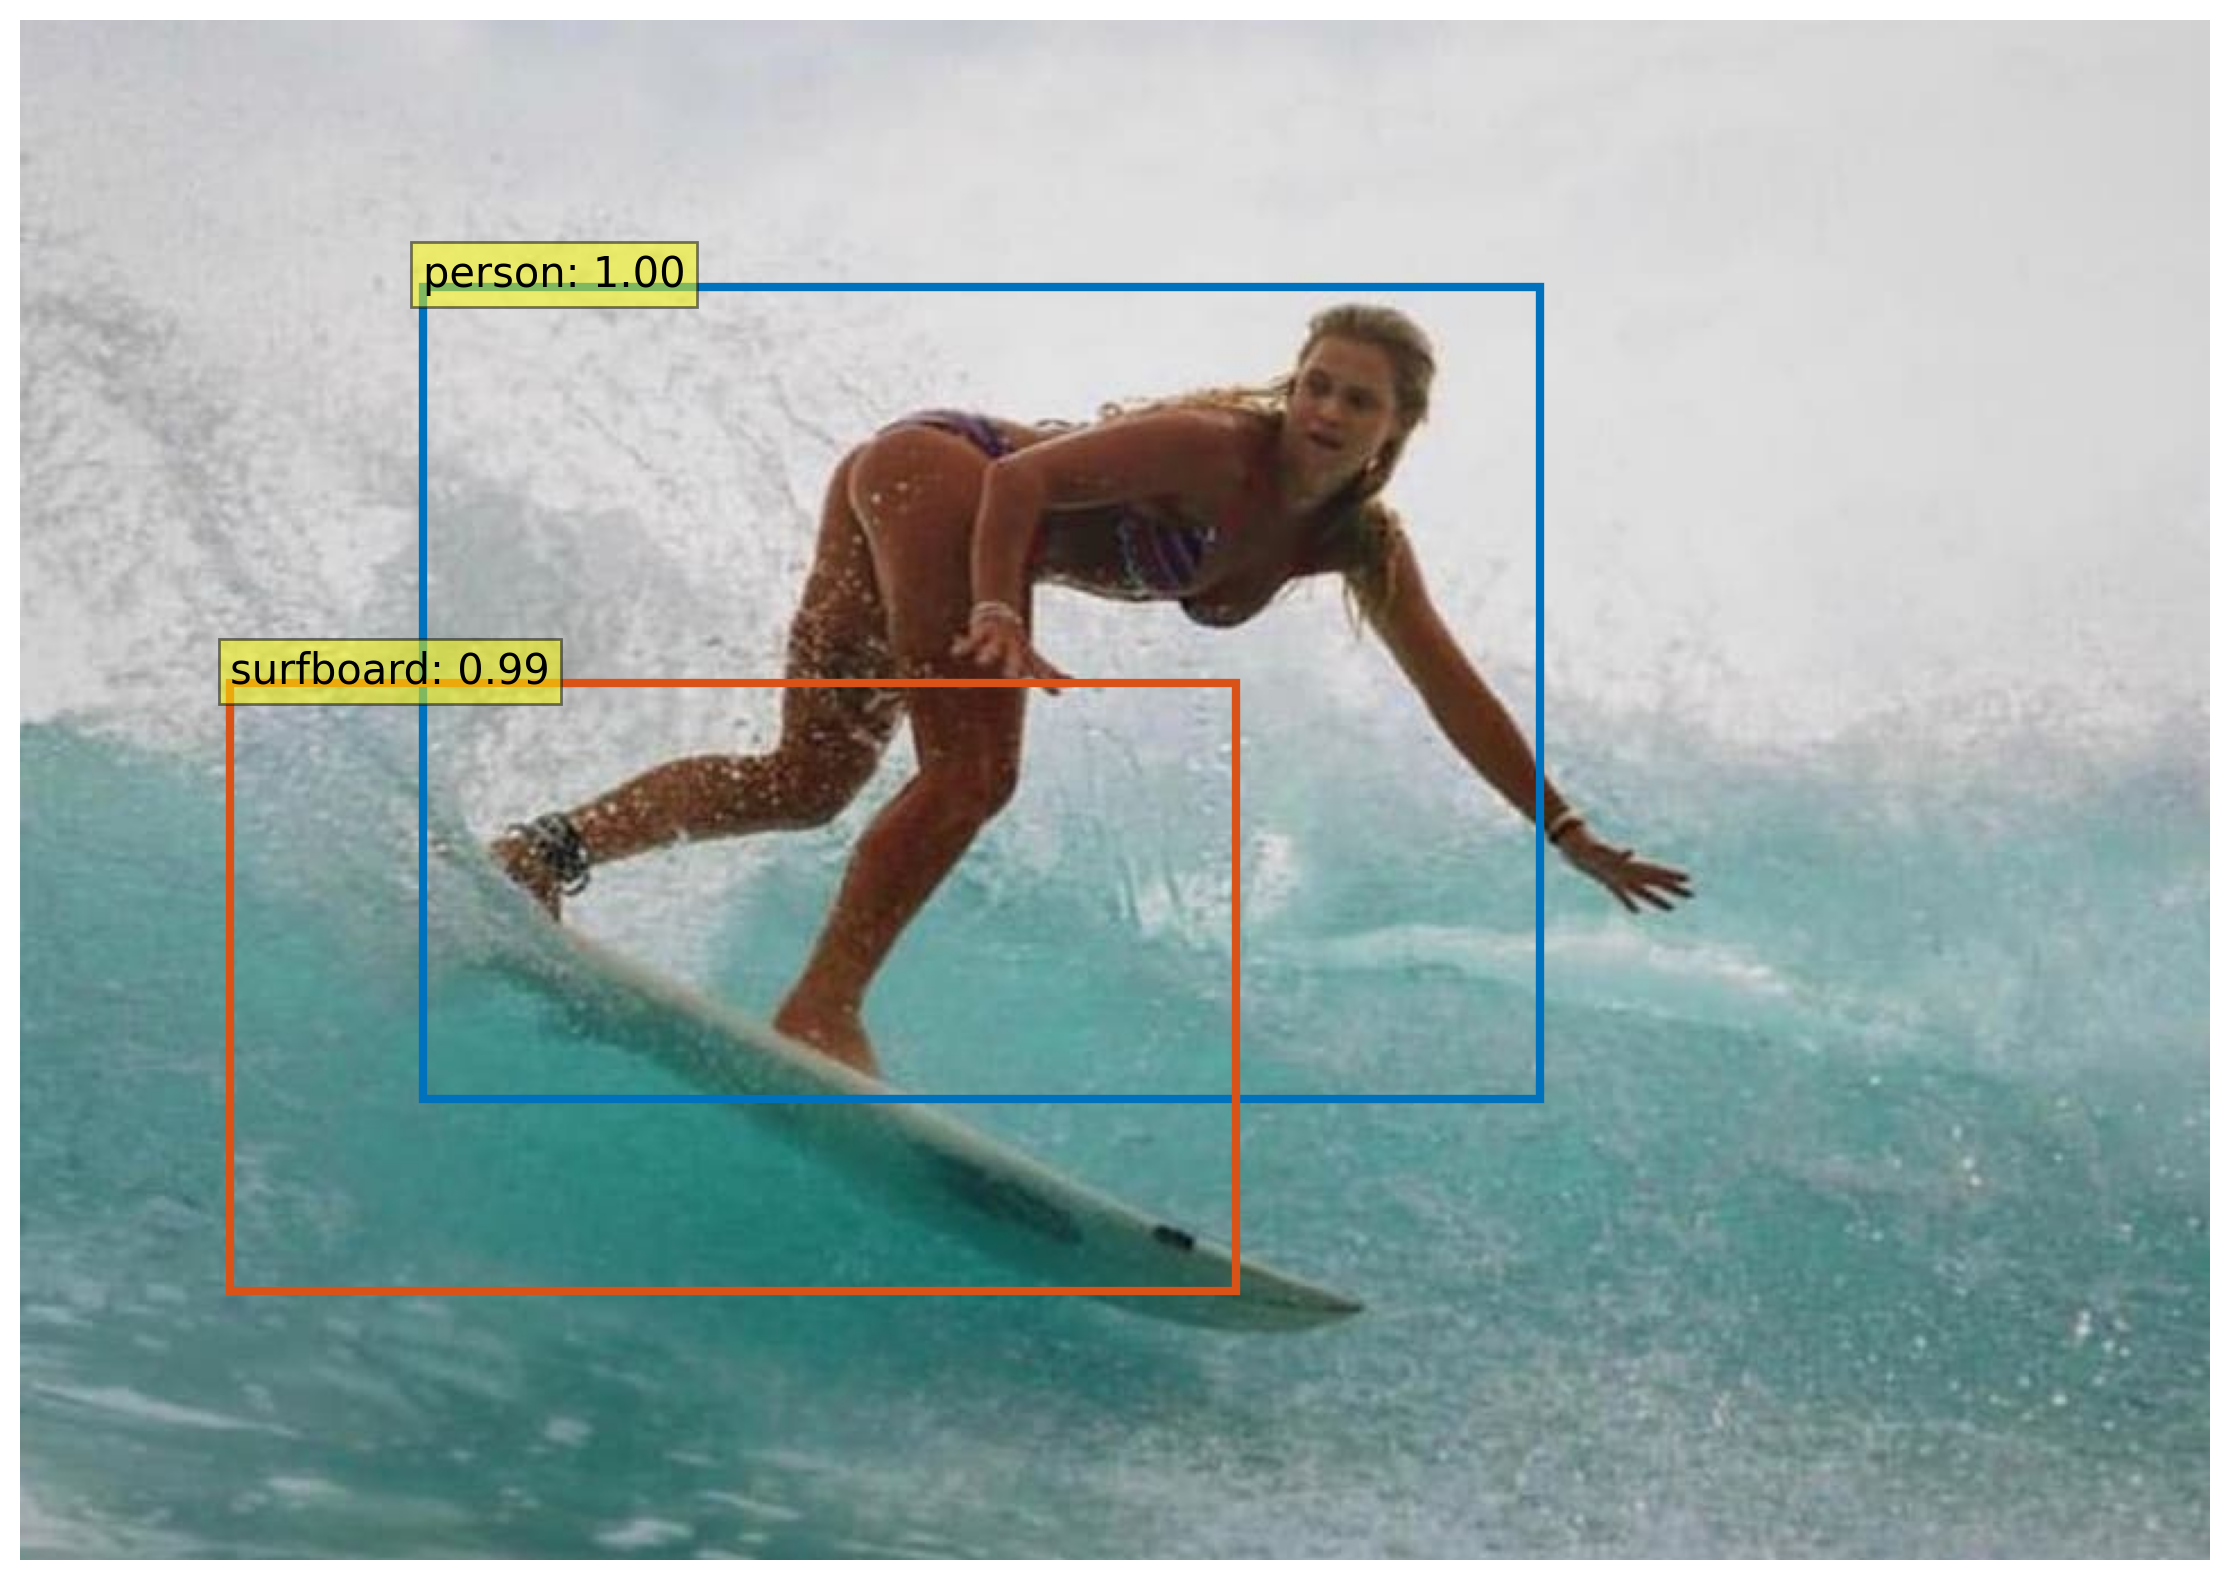

In [5]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(im, scores, boxes)

In [16]:
url = 'https://static.independent.co.uk/s3fs-public/thumbnails/image/2017/09/13/12/surfer.jpg?w968h681'
im = Image.open(requests.get(url, stream=True).raw)
transform = T.Compose([
                        T.Resize((320, 320)),
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                      ])
sample_input = transform(im).unsqueeze(0)
torch.onnx.export(detr_demo, sample_input, 'detr_demo.onnx', opset_version = 11)
# torch.onnx.export(detr, sample_input, 'detr.onnx', opset_version = 11)

In [14]:
from onnxsim import simplify

# load your predefined ONNX model
model_onnx = onnx.load('detr_demo.onnx')

# convert model
model_simp, check = simplify(model_onnx)
onnx.save(model_simp, 'detr_demo_sim.onnx')

#### Enable python3.6 environment, to use SNPE SDK and then convert onnx to dlc

In [ ]:
%%bash
snpe-onnx-to-dlc -i detr_demo.onnx -o app/src/main/assets/detr_demo.dlc

## Quantizing DETR-resnet50

In [43]:
##STEPS to preprocess images
import cv2
import numpy as np
import os

def normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    imgR = img.copy()
    imgR[:,:,0] = (img[:,:,0] - mean[2]) / std[2]
    imgR[:,:,1] = (img[:,:,1] - mean[1]) / std[1]
    imgR[:,:,2] = (img[:,:,2] - mean[0]) / std[0]
    return imgR
    
def preprocess(original_image):
    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(rgb_image, (320, 320)) #BGR image format
    resized_image = resized_image/255
    oimg = normalize(resized_image)
    return oimg

##Please download Coco2014 dataset and give the path here
dataset_path = "./coco2017/val2017/"

!mkdir -p rawDETRres50

filenames=[]
for path in os.listdir(dataset_path)[:5]:
    # check if current path is a file
    if os.path.isfile(os.path.join(dataset_path, path)):
        filenames.append(os.path.join(dataset_path, path))

for filename in filenames:
    original_image = cv2.imread(filename)
    img = preprocess(original_image)
    img = img.astype(np.float32)
    img.tofile("rawDETRres50/"+filename.split("/")[-1].split(".")[0]+".raw")

In [44]:
%%bash
find rawDETRres50 -name *.raw > DETRres50Inputlist.txt

In [ ]:
%%bash
cat DETRres50Inputlist.txt

In [ ]:
%%bash
snpe-dlc-quantize --input_dlc app/src/main/assets/detr_demo.dlc --input_list DETRres101Inputlist.txt --use_enhanced_quantizer --use_adjusted_weights_quantizer --axis_quant --output_dlc app/src/main/assets/Quant_intermediate_detr_demo_s_320.dlc


In [7]:
%%bash
snpe-dlc-graph-prepare --input_dlc app/src/main/assets/Quant_intermediate_detr_demo_s_320.dlc --set_output_tensors 2135,2139 --output_dlc app/src/main/assets/Quant_detr_demo_s_320.dlc --htp_socs sm8650

[INFO] InitializeStderr: DebugLog initialized.
[WARNING] Input[0] has Datatype 0x408.
[INFO] SNPE HTP Offline Prepare: Attempting to create cache for SM8550
[INFO] Attempting to open dynamically linked lib: libHtpPrepare.so
[INFO] dlopen libHtpPrepare.so SUCCESS handle 0x2205e30
[INFO] Found Interface Provider (v2.10)
[USER_WARNING] QnnDsp <W> Initializing HtpProvider
[USER_WARNING] QnnDsp <W> HTP arch will be deprecated, please set SoC id instead.
[USER_WARNING] QnnDsp <W> Cost Based unsupported on soc SM8550
[USER_INFO] Platform option not set
[USER_INFO] Offline Prepare VTCM size(MB) selected = 8
[USER_WARNING] QnnDsp <W> Output padding param cannot be set explicitly. Skipping param
[USER_WARNING] QnnDsp <W> Output padding param cannot be set explicitly. Skipping param



====== Prepared Graph's Summary ======
Spill fill buffer size = 0



[USER_INFO] Backend Mgr ~Dtor called for backend HTP
[USER_INFO] Cleaning up Context handle:0x1
[USER_INFO] BackendTerminate triggered
[USER_WARNING] QnnDsp <W> Device 0x1 not found in registry
[INFO] SNPE HTP Offline Prepare: Successfully created cache for SM8550
[INFO] SNPE HTP Offline Prepare: Saved cached DLC to app/src/main/assets/Quant_yoloNas_s_320.dlc
[USER_INFO] BackendTerminate triggered
[INFO] DebugLog shutting down.
